We just learned about some of the really cool things about exoplanets, how we observe them, and what we can learn from our observations. Now it's your turn to try some of this out! This notebook is meant to serve as a guide for when you'll be doing your own analysis. Reminder: This is just a start. There are many other things you could do to analyze data for your systems. 

In this notebook, we'll be using a few different code packages that mesh together. Be sure to look up what each code is doing and how it's doing it, because these are things I'll want to see in your paper. 

There are many different transit-fitting code packages, and coding doesn't have to be as daunting as you might think. If something isn't working with your code, there should be resources available to look up online, or I'll be able to help you out.


We'll start with some imports. When using Python code, you need to import the packages that you'll be using because each of those packages has their own built-in methods that we'll be using. This means we don't have to build our code completely from the ground up!

before we get going, install the proper python packages by going to Anaconda Navigator and finding the root path, then going to "Import" which should be at the bottom of the page. Run the following code in terminal

python -m pip install lightkurve

pip install emcee

pip install multiprocessing

pip install corner

pip install batman-package

THEN we can run these imports below

In [1]:
#THEN we can run these imports
#importing all the software we'll need
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy
from astropy.timeseries import BoxLeastSquares
import batman
from scipy.optimize import minimize
from IPython.display import display, Math
import emcee
from multiprocessing import Pool
from scipy.stats import binned_statistic
import time
import astropy.units as u
from multiprocessing import Pool
import corner

We'll start with searching for our star in lightkurve. Lightkurve is a really powerful tool for searching for your light curve directly from the source, but it also has a lot of great analytical tools. Here's the readthedocs: https://docs.lightkurve.org/index.html . There are some notes in the cell below about how to search for your lightcurve, but let me know if you can't find it, and we'll see if we can find it together, or I can try to find it and send it along to you.

(1842.0, 1869.0)

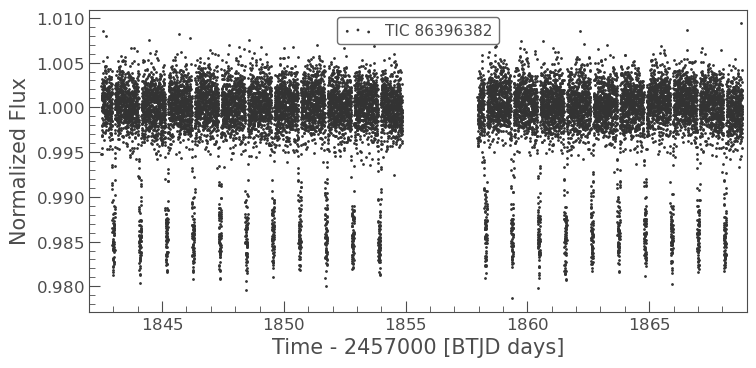

In [17]:
#ID for the star
#yours might be "TOI-470" or "Kepler-48" or something
#this should work, but if not, you can look up other identifiers for the star
star = "WASP-12b"

#as in lightkurve tutorials
lc = lk.search_lightcurve(star,author = 'SPOC',mission = 'TESS').download_all()
lc_tot = lc.stitch()
lc_tot.scatter()
plt.xlim(1842,1869)

I picked a really easy lightcurve, but you may have to do some massaging to get your lightcurve to look good. Check out the lightkurve tutorials for how to get rid of outliers in your data, how to smooth it over, and other things to make it look better. Additionally, if you have a TESS target, there may be huge gaps in your data because TESS looked at it once in its primary mission and then reobserved it a year or two later. That's okay. You'll just have to figure out how to make it easier to visualize. Perhaps downloading and viewing different sectors individually (by specifying which sector you'd like to download as an argument in search_lightcurve, and then stitching them together by using some clever numpy array tricks could work?

/Users/dom/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1056: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning,


(0.0, 20.0)

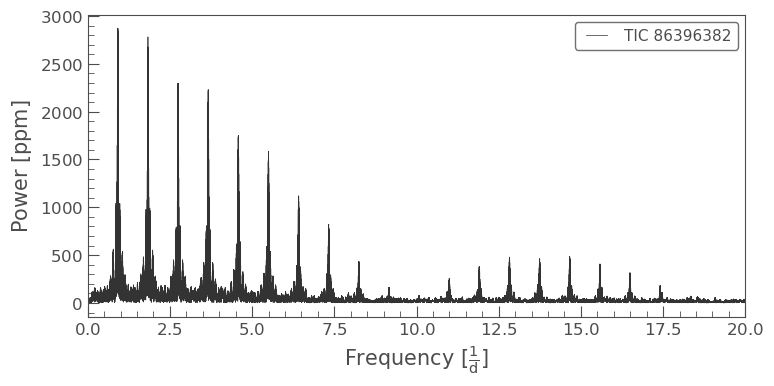

In [3]:
#periodograms are important tools to tell us about frequencies that show up in the data!
pg = lc_tot.normalize(unit='ppm').to_periodogram()
pg.plot()
plt.xlim(0,20)

In [4]:
#this will tell us more about the properties of this periodogram
pg.show_properties()

lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
              targetid                          86396382      
          default_view                         frequency      
                 label                      TIC 86396382      
             ls_method                              fast      
frequency_at_max_power                            0.9194 1 / d
             max_power                         2870.6844   ppm
               nyquist                          359.9964 1 / d
   period_at_max_power                            1.0876     d
             frequency                  array (1180096,) 1 / d
                period                  array (1180096,)     d
                 power                  array (1180096,)   ppm
                  meta <class 'collections.OrderedDict'>      


In [5]:
#what's the period?
period = pg.period_at_max_power
period

<Quantity 1.08761772 d>

So at this point, we've got our lightcurve and we've made a periodogram with it. Look a bit more into what a periodogram does, because that will be important later. Now we want to start modeling it with the BATMAN code: https://lweb.cfa.harvard.edu/~lkreidberg/batman/tutorial.html 

The first thing we'll do in the code below is assign some arrays with our time and flux information, which is the lightcurve data itself. Then, we want to make an initial guess about the system so that the model has something to converge to. You'll be able to find some of these parameters by looking up more about your target. You can find the paper it was published in, you can maybe find a Wikipedia article if you're lucky, or you can search it on the NASA Exoplanet Archive: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS, or on Exoplanet.eu: http://exoplanet.eu/

In [6]:
#assign some arrays 
time = lc_tot.time.value
flux = lc_tot.flux.value
flux_err = lc_tot.flux_err.value

#you'll find these values by looking up more about your target!
epoch_guess = 2458843.005184 - 2457000
per_guess = 1.09140989192976
rp_guess = 0.117
a_guess = 3
inc_guess = 83.52
#these become your guesses for BATMAN

The next code block looks pretty intense, but let's walk through it step by step. The first function that's defined is a log-likelihood function, which we will employ to see how well our initial guess works. It will probably work pretty well because you'll likely be using the published "best" values for your target. 

Then, the f_batman function initializes our model. You'll notice there are a lot of parameters for this function, and one of them is u. I don't want to go into too much detail about this, and the batman tutorial has some stuff about this, but essentially these are your limb darkening parameters, which tell us about the shape of the transit. We can guess based on what kind of star we are looking at, but I don't think it should matter too much for you if you don't change them. As long as we're using quadratic limb darkening parameters, it should be okay. 

The "guess" line is what our best guess is, and that's what we'll initially plug into the model. We then plug that into our minimization algorithm, which fits the model to some set of best-fit parameters. This kind of fitting algorithm is called "least squares minimization".

In [7]:
#helpful for initial minimization to view your model
def log_likelihood(theta, x, y, yerr):
#     t0, per, rp, a, inc, ecc, w, baseline = theta
    model = f_batman(x, *theta)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2. * np.pi*sigma2))


def f_batman(x, t0,per,rp,a,inc,ecc=0,w=90,baseline=0.0,u=[0.33268618,0.29510712],limb_dark ="quadratic"):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    params = batman.TransitParams()
    params.t0 = t0                     #time of inferior conjunction
    params.per = per                  #orbital period
    params.rp =  rp         #planet radius (in units of stellar radii)
    params.a = a                      #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                     #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = u                #limb darkening coefficients [u1, u2]
    params.limb_dark = limb_dark       #limb darkening model

    m = batman.TransitModel(params, x)    #initializes model
    flux_m = m.light_curve(params)          #calculates light curve
    return np.array(flux_m)+baseline


#this will be your guess to input into the model
guess = np.array([epoch_guess, per_guess, rp_guess, a_guess, inc_guess, 0.0,0.0])


# Magic:
nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, guess, args=(time, flux, flux_err))


labels = ["t0", "per", "rp", "a", "inc","ecc", 'w', ]


for idx in range(len(soln.x)):
    print("{} : {} ({})".format(labels[idx], soln.x[idx], guess[idx]))
   

t0 : 1843.0051839998923 (1843.0051839998923)
per : 1.09140989192976 (1.09140989192976)
rp : 0.117 (0.117)
a : 3.0 (3.0)
inc : 83.52 (83.52)
ecc : 0.0 (0.0)
w : 0.0 (0.0)


/Users/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


This next code block is also pretty hefty. Essentially, this phase-folds the data over itself (that will be a thing you'll have to know about later), so we can see how well our model fits. 

Text(0, 0.5, 'Normalised flux')

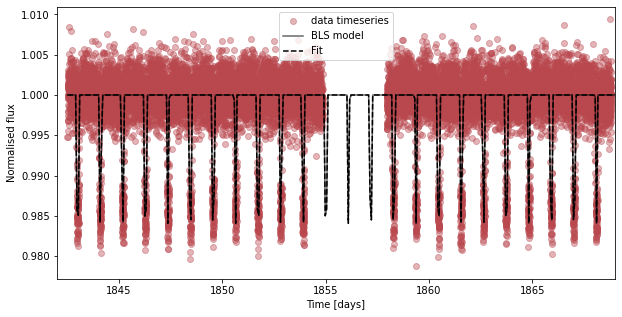

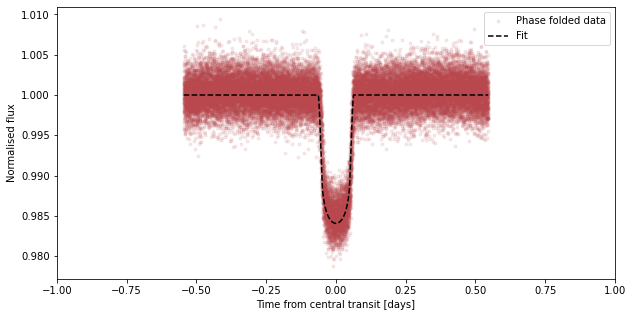

In [18]:
## compute model for BLS and fit
## Create time array for BLS model and fit:
t = np.linspace(np.min(time), np.max(time[-1]), 10000)
flux_m = f_batman(t, *guess)
flux_fit = f_batman(t, *soln.x)

## Phasefold data time-array
phase = (time - soln.x[0]) % soln.x[1] / soln.x[1]
phase[np.where(phase>0.5)] -= 1 

## Phase bls model time-array + sort
phase_blsmodel = (t - epoch_guess) % per_guess / per_guess
phase_blsmodel[np.where(phase_blsmodel>0.5)] -= 1 
sorted_idx = np.argsort(phase_blsmodel)

## phasefold fit time array + sort
phase_fit = (t - soln.x[0]) % soln.x[1] / soln.x[1]
phase_fit[np.where(phase_fit>0.5)] -= 1 
sorted_fit = np.argsort(phase_fit)

# Plot: 
## Plot data & model together, timeseries
plt.figure(figsize=(10,5))
plt.plot(time, flux, "o", color='xkcd:dusty red', label='data timeseries', alpha=0.4)
plt.plot(t, flux_m, 'k', label='BLS model', alpha=0.6)
plt.plot(t, flux_fit, '--k', label='Fit')
plt.legend()
plt.xlabel("Time [days]")
plt.ylabel("Normalised flux")
plt.xlim(1842,1869)

## Plot data & model together, phase fold
plt.figure(figsize=(10,5))
plt.plot(phase*soln.x[1], flux, ".", color='xkcd:dusty red', label='Phase folded data', alpha=0.1)
plt.plot(phase_fit[sorted_fit]*soln.x[1], flux_fit[sorted_fit], '--k', label='Fit')
plt.legend()
plt.xlim(-1, 1)
plt.xlabel("Time from central transit [days]")
plt.ylabel("Normalised flux")

Can we fit our model better than it already does? Typically, the answer is yes, but in this case the answer may be no because we're already looking at some pretty famous planets with well-known properties. This next fitting technique therefore may not be entirely necessary, but I wanted you all to see it just because it's where a lot of the good stuff happens. This next thing we'll do is employ a Markov-Chain Monte-Carlo process to find the best-fit parameters for our model. Look up what an MCMC is and does, because that will be important later.

The first thing we have to do is establish some priors for our model, which is essentially the same as providing an initial guess. We then define log_likelihood and log_prior functions, which are the function our model will use to find the best-fit values, and the function that we will use to bound the system when it's trying to converge. Finally, the log_probability function takes these two and calculates how close we are to the best-fit. 

In [9]:
#priors = t0, per,rp,a,inc,ecc,w
priors = [epoch_guess-0.05, epoch_guess+0.05,
         per_guess-0.05, per_guess+0.05,
         0,0.05,
         a_guess-2, a_guess+3,
         80.00, 90.00,
         0.0, 0.6,
         0.0,180.0]


def log_likelihood(theta, x, y, yerr):
#     t0, per, rp, a, inc, ecc, w, baseline = theta
    model = f_batman(x, *theta)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2. * np.pi*sigma2))

def log_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    t0,per,rp,a,inc,ecc,w = theta
    # We're using only uniform priors:
    if priors[0] > t0 or t0 > priors[1]:
        return -np.inf
    if per > priors[3] or per < priors[2]:
        return -np.inf
    if rp > priors[5] or rp < priors[4]:
        return -np.inf
    if a > priors[7] or a < priors[6]:
        return -np.inf
    if inc > priors[9]:
        return -np.inf
    if ecc > priors[11] or ecc < 0:
        return -np.inf
    if w > priors[13]:
        return -np.inf
    return 0.0

## The full log-probability function is:

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
print("arrived")

arrived


The cell below is the actual MCMC code block, which is managed by the 'emcee' (https://emcee.readthedocs.io/en/stable/) code package. This is a pretty sophisticated program, so there shouldn't be much that you have to change here. The thing when you're doing your own fit that may or may not get things to work or crash is the 'order_of_mag' line, which tells the code how to distribute the random walkers. If you distribute the walkers too far from each other, the fit won't converge, but if you distribute them too close to one another, they won't effectively sample the parameter space. You'll see an example of this below because the initial guess we had was already pretty good.

In [10]:
ndim = len(soln.x)
nwalkers = ndim*8  # Number of walkers. It is recommended to be at least higher than twice 
                   # the amount of parameters being fit


# theta = [t0,per,rp,a,inc,ecc,w]
order_of_mag = np.array([0.001, 0.001, 0.01, 0.1, 0.1, .1,1])

pos = soln.x + order_of_mag * np.random.randn(nwalkers, ndim)

# If you want to use parallelization
with Pool() as pool:
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_t, flux_t, flux_error_t),pool=pool)
    # This line below will fit the entire data set, incl OOT. Time consuming.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_err),pool=pool)
    sampler.run_mcmc(pos, 10000, progress=True)
    

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/dom/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [11:02<00:00, 15.10it/s]


The code block below gives us the positions of the random walkers as they're walking. What has happened here?

/Users/dom/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


[nan nan nan nan nan nan nan]


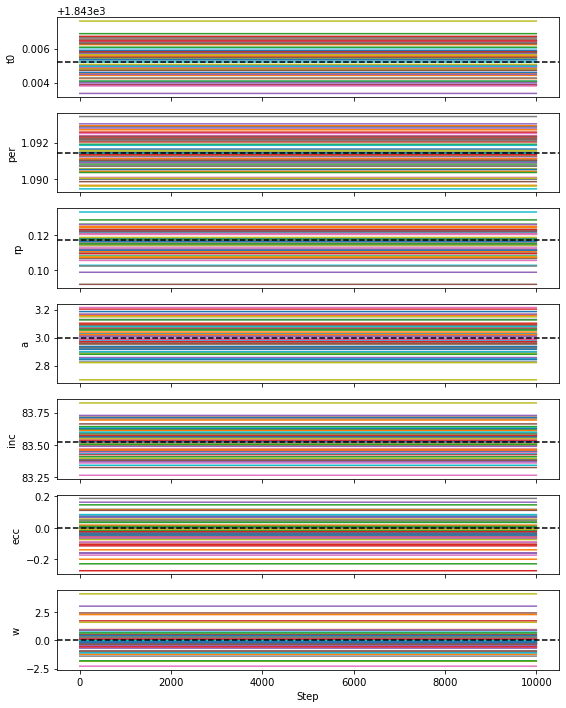

In [11]:
try:
    tau = sampler.get_autocorr_time()
    print(tau)
except:
    print('Tau bad!')
    
fig, axes = plt.subplots(ndim, sharex=True, figsize=(9.0, 12.0))

for i in range(ndim):
    axes[i].plot(sampler.chain[:,:,i].T)
    axes[i].set_ylabel(labels[i])
    axes[i].axhline(y=soln.x[i], linestyle='--', lw=1.5, color='k')
axes[-1].set_xlabel('Step')
plt.show() 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

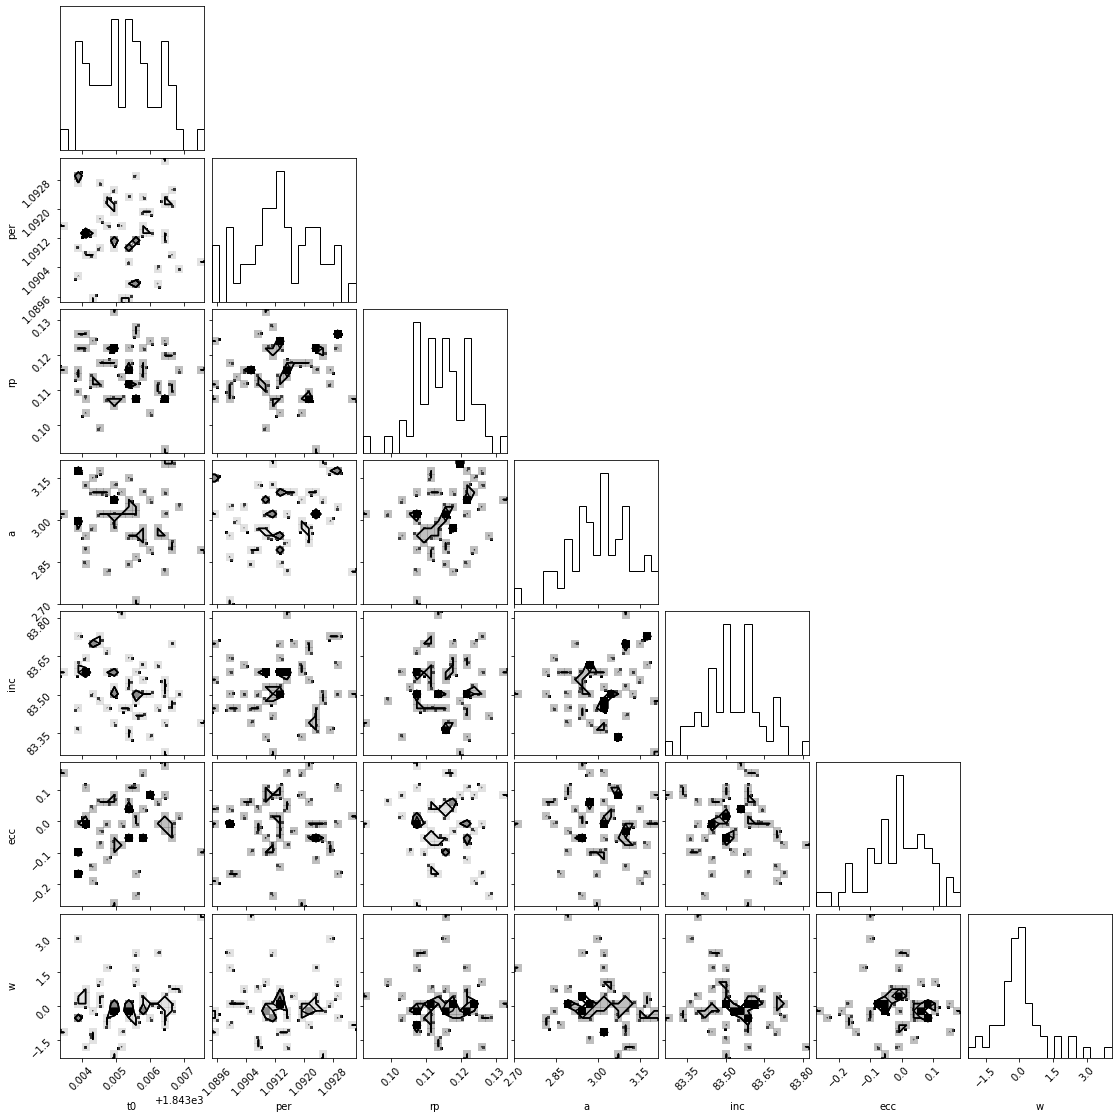

In [12]:
# flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)
flat_samples = sampler.get_chain(discard=500, thin=20, flat=True)


fit = np.array([])

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    fit = np.append(fit, [mcmc[1]])
    
fig = corner.corner(flat_samples, labels=labels)
    

A corner plot like the one above is a way of comparing relationships between all of the sampled 

[1.84300518e+03 1.09140989e+00 1.17000000e-01 3.00000000e+00
 8.35200000e+01 0.00000000e+00 0.00000000e+00]
[ 1.84300535e+03  1.09130175e+00  1.14958406e-01  3.01865208e+00
  8.35150901e+01 -8.13477905e-03 -8.48675381e-02]


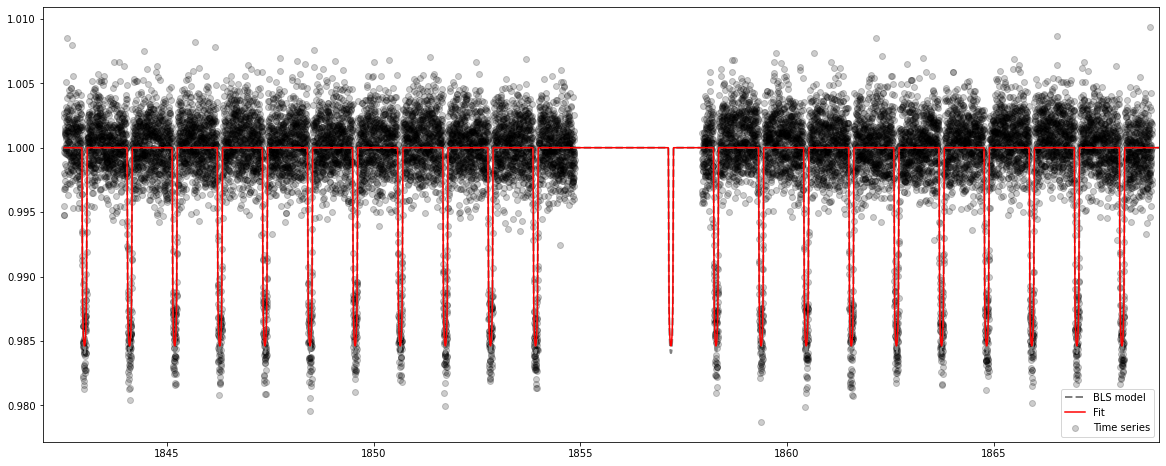

In [19]:
print(guess)


transit_fit = fit[:-1]

print(fit)

plt.figure(figsize=(20,8))

flux_m = f_batman(time, *guess)
plt.plot(time, flux_m, '--', color='gray', label='BLS model', lw=2, zorder=3)

flux_m = f_batman(time, *fit )
plt.plot(time, flux_m, 'k',color='red',label='Fit', lw=1.5, zorder=10)
plt.scatter(time, flux,marker="o", color='black', label='Time series', alpha=0.2)
plt.xlim(1842,1869)
plt.legend()

# Questions

Write at least one sentence (but preferably more, especially if the answer calls for it) to answer each of these questions. You can answer these questions in a "markdown" cell below this one (if there isn't already a markdown cell below this one, then create a "markdown" cell by clicking cell in the menu bar above, then finding "cell type", then selecting "markdown").

1. (2 pts) What are our imports at the beginning of the lab for?
2. (4 pts) How do we characterize the atmospheres of exoplanets? You may need to look this up.
3. (2 pts) What exactly is a light curve?
4. (3 pts) What is a periodogram and what does it tell us? (you may want to rely on https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html or other sources)
5. (4 pts) What are the two kinds of fitting algorithms we've used? (just listing them here is okay)
6. (3 pts) What does an MCMC algorithm do? You may want to look this up.
7. (4 pts) What happened to the MCMC fit performed for this analysis? Did it converge?
8. (5 pts) What is an exoplanet occurrence rate? How is it calculated? You may need to look this up.
9. (5 pts) How do we determine planet radii? How do we determine planet masses? Can these be found by the same methods?
10. (3 pts) Which exoplanet detection method has yielded the most exoplanet detections to date? why would this be?
11. (4 pts) What are some interesting things you're looking forward to learning about exoplanets?